In [1]:
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kipoi_cadd.data import CaddSparseDataset, cadd_sparse_train_valid_data_one, sparse_cadd_dataset
from kipoi_cadd.models import logistic_regression_keras
from sklearn.externals import joblib
%matplotlib inline

Using TensorFlow backend.


## 1. Compare models
### 1.a. Accuracy with CADD's model
Obtain predictions from CADD's as provided on [github](https://github.com/kircherlab/CADD-scripts/blob/master/data/models/GRCh37/CADD1.4-GRCh37.mod) of our sparse matrices generated with `kipoi-cadd/src/02_retrain_cadd_v1.4/generate_datasets.py`.

In [2]:
model_cadd_file = "/s/project/kipoi-cadd/data/models/CADD1.4-GRCh37.mod"
all_npz_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sparse_matrices/all.npz"
all_id_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/variant_ids/all.pkl"

In [3]:
model_cadd, scaler_cadd = joblib.load(model_cadd_file)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
ds = CaddSparseDataset(all_npz_file, all_id_file, "v1.4")
X, y = ds.load_all()
X_scaled = scaler_cadd.transform(X)

In [5]:
model_cadd.score(X_scaled, y)

0.5306579702938102

### 1.b. Accuracy with our model
KipoiCADD's model. LogisticRegression trained with the following hyperparameters:
 - C = 1
 - solver = 'lbfgs'
 - tolerance = 0.0001
 - max_iter = 13
 - warm_start = True

In [6]:
# Score our model and scale data with CADD's scaler
model_kipoicadd_file = "/tmp/gin-train/b604706053864563b7457641faf7bc00/model.h5"
model_kipoicadd = joblib.load(model_kipoicadd_file)
model_kipoicadd.score(X_scaled, y)

0.9718592748867122

In [7]:
# Score our model and scale data with our scaler
scaler_kipoicadd_train_file = "/s/project/kipoi-cadd/data/models/KipoiCadd_train-GRCh37.scaler"
scaler_kipoicadd_train = joblib.load(scaler_kipoicadd_train_file)

ds = CaddSparseDataset(all_npz_file, all_id_file, "v1.4") # reload data just in case
X, y = ds.load_all()
X_scaled_kipoicadd = scaler_kipoicadd_train.transform(X)

model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
model_kipoicadd.score(X_scaled_kipoicadd, y)

0.9644548286862165

### 1.c. Compare coeficients

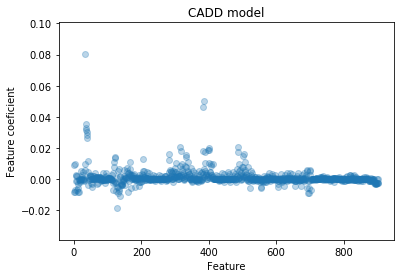

In [8]:
# Plot coeficients
model_cadd, scaler_cadd = joblib.load(model_cadd_file) # reload model and scaler just in case
plt.scatter(range(model_cadd.coef_.shape[1]), model_cadd.coef_.ravel(), alpha=0.3);
plt.xlabel("Feature")
plt.ylabel("Feature coeficient")
plt.title("CADD model")
plt.show()

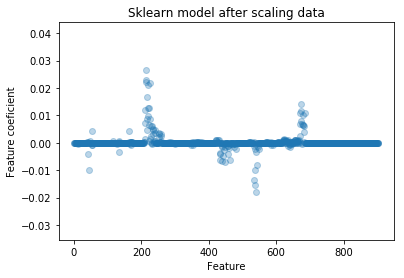

In [9]:
# Plot coeficients
model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
plt.scatter(range(model_kipoicadd.coef_[0].shape[0]), model_kipoicadd.coef_[0], alpha=0.3);
plt.xlabel("Feature");
plt.ylabel("Feature coeficient");
plt.title("Sklearn model after scaling data");

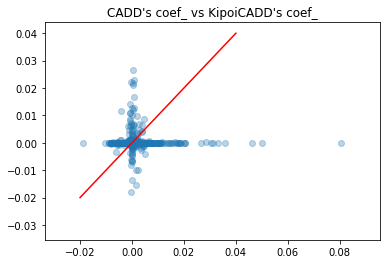

In [10]:
# Plot coeficients
model_cadd, _ = joblib.load(model_cadd_file) # reload model just in case
model_kipoicadd = joblib.load(model_kipoicadd_file) # reload model just in case
plt.scatter(model_cadd.coef_, model_kipoicadd.coef_, alpha=0.3);
plt.title("CADD's coef_ vs KipoiCADD's coef_");
plt.plot([-0.02, 0.04], [-0.02, 0.04], color='red');

## 2. Compare scalers
### 2.a Generate our own scaler
_You may skip this part as the scaler has already been generated and saved._

In [ ]:
train_npz_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sparse_matrices/train.npz" # Shape (23244593, 905) first column is y
train_id_file = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/variant_ids/train.pkl"

In [ ]:
ds = CaddSparseDataset(train_npz_file, train_id_file, "v1.4")
scaler_kipoicadd_train = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train, y_train = ds.load_all()
scaler_kipoicadd_train.fit(X_train)
joblib.dump(scaler_kipoicadd_train, scaler_kipoicadd_train_file)

### 2.b. Compare means and variances
Our scaler trained on the training set vs. scaler from CADD

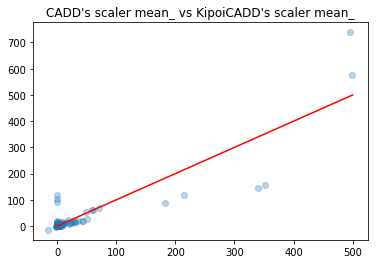

In [11]:
scaler_kipoicadd_train = joblib.load(scaler_kipoicadd_train_file) # reload scaler just in case
_, scaler_cadd = joblib.load(model_cadd_file) # reload scaler just in case
plt.scatter(scaler_cadd.mean_, scaler_kipoicadd_train.mean_, alpha=0.3);
plt.title("CADD's scaler mean_ vs KipoiCADD's scaler mean_");
plt.plot([0, 500], [0, 500], color='red');

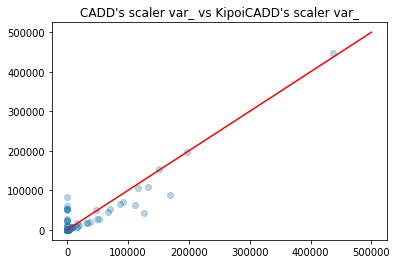

In [12]:
plt.scatter(scaler_cadd.var_, scaler_kipoicadd_train.var_, alpha=0.3);
plt.title("CADD's scaler var_ vs KipoiCADD's scaler var_");
plt.plot([0, 500000], [0, 500000], color='red');